# EQWorks challenge (PySpark)

In [1]:
import findspark

findspark.init("C:\spark\spark")

from pyspark import SparkContext, SQLContext, SparkConf
sc = SparkContext()

sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)

We first read-off the files from Github repository. We will use the raw data. The DataSample.csv file contains 22015 rows while POIList.csv only 4.

In [3]:
from pyspark import SparkFiles

url1 = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/DataSample.csv"
sc.addFile(url1)

df_DataSample = spark.read.csv(SparkFiles.get("DataSample.csv"), header=True)

In [4]:
df_DataSample.show()

+-------+--------------------+-------+--------+------------+--------+---------+
|    _ID|              TimeSt|Country|Province|        City|Latitude|Longitude|
+-------+--------------------+-------+--------+------------+--------+---------+
|4516516|2017-06-21 00:00:...|     CA|      ON|    Waterloo|43.49347|-80.49123|
|4516547|2017-06-21 18:00:...|     CA|      ON|      London|42.93990|-81.27090|
|4516550|2017-06-21 15:00:...|     CA|      ON|      Guelph|43.57760|-80.22010|
|4516600|2017-06-21 15:00:...|     CA|      ON|   Stratford|43.37160|-80.97730|
|4516613|2017-06-21 15:00:...|     CA|      ON|   Stratford|43.37160|-80.97730|
|4516693|2017-06-21 14:00:...|     CA|      ON|   Kitchener|43.43810|-80.50990|
|4516771|2017-06-21 10:00:...|     CA|      ON|      Sarnia|42.96100|-82.37300|
|4516831|2017-06-21 12:00:...|     CA|      ON|      London|43.00910|-81.17650|
|4516915|2017-06-21 15:00:...|     CA|      ON|      London|43.00910|-81.17650|
|4516953|2017-06-21 16:00:...|     CA|  

In [5]:
df_DataSample.count()

22025

In [6]:
url2 = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/POIList.csv"
sc.addFile(url2)

df_POIList = spark.read.csv(SparkFiles.get("POIList.csv"), header=True)

df_POIList.show()

+-----+----------+------------+
|POIID|  Latitude|   Longitude|
+-----+----------+------------+
| POI1| 53.546167| -113.485734|
| POI2| 53.546167| -113.485734|
| POI3| 45.521629|  -73.566024|
| POI4| 45.224830|  -63.232729|
+-----+----------+------------+



## Part 0: Cleaning 

Let's first look at the duplicated rows that have have identical geoinfo and timest entries; these rows are deemed suspicious. Analysis shows that there are 2026 such rows.

In [7]:
df_DataSample.columns

['_ID', ' TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude']

In [8]:
df_POIList.columns

['POIID', ' Latitude', 'Longitude']

We first for convenience remove spaces and underscores from two names of the columns at the beginning of each name in the df_DataSample dataframe; we then subsequently remove space from the name of one of the columns of the df_POIList dataframe.

In [9]:
df_DataSample = df_DataSample.withColumnRenamed('_ID', 'ID')

In [10]:
df_DataSample = df_DataSample.withColumnRenamed(' TimeSt', 'TimeSt')

#df_DataSample.show(10)

In [11]:
df_POIList = df_POIList.withColumnRenamed(' Latitude', 'Latitude')

Let's remove the duplicate rows in the df_DataSample dataframe. We are now down to 19999 rows.

In [12]:
df_DataSample = df_DataSample.dropDuplicates(subset=['TimeSt','Latitude', 'Longitude'])

df_DataSample.count()

19999

We also see that there are duplicate rows in the POIList.csv file. We remove one of the rows there as well.

In [13]:
df_POIList = df_POIList.dropDuplicates(subset=['Latitude', 'Longitude'])
df_POIList.show()

+-----+----------+------------+
|POIID|  Latitude|   Longitude|
+-----+----------+------------+
| POI3| 45.521629|  -73.566024|
| POI1| 53.546167| -113.485734|
| POI4| 45.224830|  -63.232729|
+-----+----------+------------+



We need to convert the Latitude and Longitude values in the df_DataSample and df_POIList dataframes to float type.

In [14]:
from pyspark.sql.functions import col

for col_name in ['Latitude', 'Longitude']:
    df_DataSample = df_DataSample.withColumn(col_name, col(col_name).cast('float'))
    
for col_name in ['Latitude', 'Longitude']:
    df_POIList = df_POIList.withColumn(col_name, col(col_name).cast('float'))

##  Part 1: Label 

Let's assign each request to one of the POI locations that has a minimum distance to the request location. We will be using Pythagorean distance only for simplicity, which of course does not have much to do with reality. We in fact assume that we work on the plane map of the world. One should use Haversine or Vincenty distance and make plots on a sphere. 

In [15]:
from numpy import argmin
from math import sqrt


data1  = [[i.POIID, i.Latitude, i.Longitude] for i in df_POIList.select(['POIID', 
        'Latitude', 'Longitude']).collect()]

def euclidean2D(x1, x2, y1, y2):
    return sqrt((x2 - x1)**2 + (y2 - y1)**2)

def euclfunc(x, y, data1):
    
    auxlist= []
    
    for i in range(len(data1)):
        auxlist.append(euclidean2D(x, data1[i][1], y, data1[i][2]))
    
    k = argmin(auxlist)
    
    return (data1[k][0], auxlist[k])



data2 = [[i.ID, i.Latitude, i.Longitude]  for i in df_DataSample.select(['ID',
        'Latitude', 'Longitude']).collect()]

data_array = []
for m in range(len(data2)):
    
    aa = euclfunc(data2[m][1], data2[m][2], data1)
    
    data_array.extend([(data2[m][0], aa[0], aa[1])])
    
df_aux = spark.createDataFrame(data = data_array, schema = ["ID", "Nearest_POIID", "Distance"])


df_DataSample = df_DataSample.join(df_aux, df_DataSample.ID == df_aux.ID)

df_DataSample.show(5)

+-------+--------------------+-------+--------+----------+--------+---------+-------+-------------+------------------+
|     ID|              TimeSt|Country|Province|      City|Latitude|Longitude|     ID|Nearest_POIID|          Distance|
+-------+--------------------+-------+--------+----------+--------+---------+-------+-------------+------------------+
|5373332|2017-06-21 00:00:...|     CA|      ON|Burlington| 43.3889| -79.7682|5373332|         POI3|6.5586244725946035|
|4750350|2017-06-21 00:15:...|     CA|      ON|    Barrie| 44.4015| -79.6782|4750350|         POI3| 6.213965821656383|
|5185275|2017-06-21 00:46:...|     CA|      NB|   Moncton| 46.1183| -64.7338|5185275|         POI4|1.7468563035457823|
|5390977|2017-06-21 01:02:...|     CA|      ON|   Toronto| 43.6477| -79.4174|5390977|         POI3| 6.144115717141835|
|4708400|2017-06-21 01:12:...|     CA|      AB|  Red Deer| 52.2651| -113.794|4708400|         POI1|1.3176342897217976|
+-------+--------------------+-------+--------+-

Let's print the maximum and minimum values of the longitude and latitude.

In [16]:
print('The maximum value of latitude is:', 
      df_DataSample.groupby().max('Latitude').collect()[0].asDict()['max(Latitude)'])
print('The minimum value of latitude is:', 
      df_DataSample.groupby().min('Latitude').collect()[0].asDict()['min(Latitude)'])
print('The maximum value of longitude is:', 
      df_DataSample.groupby().max('Longitude').collect()[0].asDict()['max(Longitude)'])
print('The minimum value of longitude is:', 
      df_DataSample.groupby().min('Longitude').collect()[0].asDict()['min(Longitude)'])

The maximum value of latitude is: 62.827301025390625
The minimum value of latitude is: 6.927420139312744
The maximum value of longitude is: 125.70220184326172
The minimum value of longitude is: -136.53956604003906


We see that there are some suspicious data that involve the positive longitudes. There are 22 such entries, and these data seem extreme and suspicious. Let's remove them. 

In [17]:
df_DataSample.filter(df_DataSample.Longitude > 0).count()

22

In [18]:
df_DataSample = df_DataSample.filter(df_DataSample.Longitude < 0)

Let's now print the maximal and minimal values of the latitude and longitude once again. Now, the data seem much more reasonable.

In [19]:
min_lat = df_DataSample.groupby().min('Latitude').collect()[0].asDict()['min(Latitude)']
max_lat = df_DataSample.groupby().max('Latitude').collect()[0].asDict()['max(Latitude)']
min_lon = df_DataSample.groupby().min('Longitude').collect()[0].asDict()['min(Longitude)']
max_lon = df_DataSample.groupby().max('Longitude').collect()[0].asDict()['max(Longitude)']

print('The maximum value of latitude is:', max_lat)
print('The minimum value of latitude is:', min_lat)
print('The maximum value of longitude is:', max_lon)
print('The minimum value of longitude is:', min_lon)

The maximum value of latitude is: 62.827301025390625
The minimum value of latitude is: 42.05400085449219
The maximum value of longitude is: -52.65660095214844
The minimum value of longitude is: -136.53956604003906


## Part 2: Analysis 

For each POI, we calculate the average and standard deviation of distances between a given POI location and each of its assigned requests. We also compute the total number of requests for each POI, the radius (given by the maximum distance for a given POI) and density (request count/circle area) for each POI location. We create the corresponding four columns and add them to df_POIList dataframe. We will use the groupby and joining operations.

In [20]:
df_DataSample.persist()

DataFrame[ID: string, TimeSt: string, Country: string, Province: string, City: string, Latitude: float, Longitude: float, ID: string, Nearest_POIID: string, Distance: double]

In [21]:
from pyspark.sql.functions import mean, max, stddev, count
from math import pi

df_POIList = df_POIList.join( df_DataSample.select(['Nearest_POIID', 'Distance']).
                             groupBy('Nearest_POIID').\
agg( mean("Distance").alias("Distance_Mean"), stddev("Distance").alias("Distance_Std"),
max("Distance").alias("Radius"), count("Distance").alias("Req_number") ),
                              df_POIList.POIID == df_DataSample.Nearest_POIID ).\
                             drop('Nearest_POIID')

df_POIList = df_POIList.withColumn('Density', df_POIList.Req_number/(pi*(df_POIList.Radius**2)) )
                                   
df_POIList.persist()

df_POIList.select(['POIID', 'Distance_Mean', 'Distance_Std', 'Radius',
                  'Req_number', 'Density']).show()                           

+-----+-----------------+------------------+------------------+----------+------------------+
|POIID|    Distance_Mean|      Distance_Std|            Radius|Req_number|           Density|
+-----+-----------------+------------------+------------------+----------+------------------+
| POI4|2.871911475193963| 2.866710836537531|10.821120739708647|       462|1.2558784757192816|
| POI1|3.348182332186283| 3.858489646840603| 24.85193540990645|      9698| 4.998179796220509|
| POI3|5.537950281140558|2.8586896565248407|20.155375951139405|      9817| 7.692138790575409|
+-----+-----------------+------------------+------------------+----------+------------------+



We now make the scatter plots of requests related to each POI with the circles centered at the coresponding POI locations. 

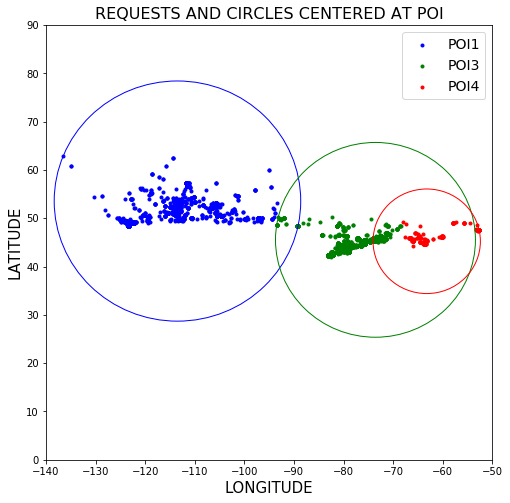

In [22]:
from matplotlib import pyplot as plt


plt.figure(figsize=(8,8))
ax = plt.gca()

plt.scatter(\
[i.Longitude for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI1').\
 select('Longitude').collect()],
[i.Latitude for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI1').
 select('Latitude').collect()],
           color = 'b', marker = '.', label='POI1')

plt.scatter(\
[i.Longitude for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI3').\
 select('Longitude').collect()],
[i.Latitude for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI3').
 select('Latitude').collect()],
           color = 'g', marker = '.', label='POI3')

plt.scatter(\
[i.Longitude for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI4').\
 select('Longitude').collect()],
[i.Latitude for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI4').
 select('Latitude').collect()],
           color = 'r', marker = '.', label='POI4')


plt.ylim((0,90))
plt.xlim((-140,-50))

circle0 = plt.Circle(\
( df_POIList.filter(df_POIList.POIID == 'POI1').select('Longitude').collect()[0][0], 
  df_POIList.filter(df_POIList.POIID == 'POI1').select('Latitude').collect()[0][0] ), 
  df_POIList.filter(df_POIList.POIID == 'POI1').select('Radius').collect()[0][0] ,
          color = 'b', fill = False )
ax.add_artist(circle0)

circle1 = plt.Circle(\
( df_POIList.filter(df_POIList.POIID == 'POI3').select('Longitude').collect()[0][0], 
  df_POIList.filter(df_POIList.POIID == 'POI3').select('Latitude').collect()[0][0] ), 
  df_POIList.filter(df_POIList.POIID == 'POI3').select('Radius').collect()[0][0] ,
          color = 'g', fill = False )
ax.add_artist(circle1)


circle2 = plt.Circle(\
( df_POIList.filter(df_POIList.POIID == 'POI4').select('Longitude').collect()[0][0], 
  df_POIList.filter(df_POIList.POIID == 'POI4').select('Latitude').collect()[0][0] ), 
  df_POIList.filter(df_POIList.POIID == 'POI4').select('Radius').collect()[0][0] ,
          color = 'r', fill = False )
ax.add_artist(circle2)

plt.xlabel('LONGITUDE', fontsize =15)
plt.ylabel('LATITUDE', fontsize =15)
plt.legend(fontsize = 14)
plt.title('REQUESTS AND CIRCLES CENTERED AT POI', fontsize =16)

plt.show()

## Model: Part 1

Let's compute the mean of the density, averaged over all three POI, as well as the corresponding standard deviation.

In [23]:
dens_mean = df_POIList.groupby().agg(mean('Density')).collect()[0][0]
dens_std = df_POIList.groupby().agg(stddev('Density')).collect()[0][0]

print('The mean of the Density is:', dens_mean)
print('The standard deviation of the Density is:', dens_std)

The mean of the Density is: 4.648732354171734
The standard deviation of the Density is: 3.2323283939311915


We can consider the following mathematical model. The unit of area corresponds to the one degree longitude by one degree longitude square. We break the whole area of interest into unit squares and count the number of requests that came from each square. We first create the new data frame df_Densities with four columns: latitude of the center of a square, longitude of the center of a square, numbers of requests that came from that square and the nearest POI.

In [24]:
lat_cent = []
lon_cent = []
num_req = []
near_poi = []

m = int(max_lon - min_lon)
n = int(max_lat - min_lat)
del_lon = (max_lon - min_lon)/m
del_lat = (max_lat - min_lat)/n

 
for i in range(m):
    for j in range(n):
        lon_cent.append(min_lon +(i+0.5)*del_lon)
        lat_cent.append(min_lat +(j+0.5)*del_lat)
        
        mask = (min_lon +i*del_lon <= df_DataSample.Longitude) & \
            (df_DataSample.Longitude < min_lon +(i+1)*del_lon) & \
            (min_lat +j*del_lat <= df_DataSample.Latitude) & \
            (df_DataSample.Latitude < min_lat +(j+1)*del_lat)
        
        num_req.append(df_DataSample.filter(mask).count())
        
        auxlist= []
        for l in range(len(data1)):
            auxlist.append(euclidean2D(min_lat +(j+0.5)*del_lat, data1[l][1],
                      min_lon +(i+0.5)*del_lon, data1[l][2]))
        k = argmin(auxlist)
        near_poi.append(data1[k][0])
 

data_array1 = []
for m in range(len(lat_cent)):    
    data_array1.extend([(lat_cent[m], lon_cent[m], num_req[m], near_poi[m])])
    
df_Densities = spark.createDataFrame(data = data_array1, schema = ['Lat_centers',
                            'Lon_centers', 'Req_number', 'Nearest_POIID'])


df_Densities.show(10)

+------------------+-------------------+----------+-------------+
|       Lat_centers|        Lon_centers|Req_number|Nearest_POIID|
+------------------+-------------------+----------+-------------+
| 42.57333335876465|-136.03424697324454|         0|         POI1|
| 43.61199836730957|-136.03424697324454|         0|         POI1|
| 44.65066337585449|-136.03424697324454|         0|         POI1|
| 45.68932838439942|-136.03424697324454|         0|         POI1|
|46.727993392944335|-136.03424697324454|         0|         POI1|
| 47.76665840148926|-136.03424697324454|         0|         POI1|
| 48.80532341003418|-136.03424697324454|         0|         POI1|
|  49.8439884185791|-136.03424697324454|         0|         POI1|
|50.882653427124026|-136.03424697324454|         0|         POI1|
|51.921318435668944|-136.03424697324454|         0|         POI1|
+------------------+-------------------+----------+-------------+
only showing top 10 rows



We now consider the mapping of the densities (the numbers of requests per unit square) onto the scale from -10 to 10. The mapping function will be created as follows: 0 requests correspond to -10, 1 request corresponds to -8, 2 yo -6, 3 to -4, 4 to -2, 5 (near average value) to 0, 6,7 to 2, 8,9 requests to 4, 10,11 to 6, 12,13 to 8, while 14 requests or more to 10. The new column with scaled density will be added to the dataframe.

In [25]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

def map_func(k):
    if k == 0: return -10
    elif k == 1: return -8
    elif k == 2: return -6
    elif k == 3: return -4
    elif k == 4: return -2
    elif k == 5: return 0
    elif (k == 6)| (k == 7): return 2
    elif (k == 8)| (k == 9): return 4
    elif (k == 10)| (k == 11): return 6
    elif (k == 12)| (k == 13): return 8
    else: return 10
    
map_func_udf = udf(lambda z: map_func(z), IntegerType())

df_Densities = df_Densities.withColumn('Scaled_density', map_func_udf(col('Req_number')))

df_Densities.persist()

df_Densities.show(10)

+------------------+-------------------+----------+-------------+--------------+
|       Lat_centers|        Lon_centers|Req_number|Nearest_POIID|Scaled_density|
+------------------+-------------------+----------+-------------+--------------+
| 42.57333335876465|-136.03424697324454|         0|         POI1|           -10|
| 43.61199836730957|-136.03424697324454|         0|         POI1|           -10|
| 44.65066337585449|-136.03424697324454|         0|         POI1|           -10|
| 45.68932838439942|-136.03424697324454|         0|         POI1|           -10|
|46.727993392944335|-136.03424697324454|         0|         POI1|           -10|
| 47.76665840148926|-136.03424697324454|         0|         POI1|           -10|
| 48.80532341003418|-136.03424697324454|         0|         POI1|           -10|
|  49.8439884185791|-136.03424697324454|         0|         POI1|           -10|
|50.882653427124026|-136.03424697324454|         0|         POI1|           -10|
|51.921318435668944|-136.034

Finally, we will plot the results using the scatter plot using the variable marker sizes. The unit areas that have greater than average scaled density are denoted with circles of blue green and red color, while those with smaller than average scaled density are represented with the lighter shadows of the abovementined colors

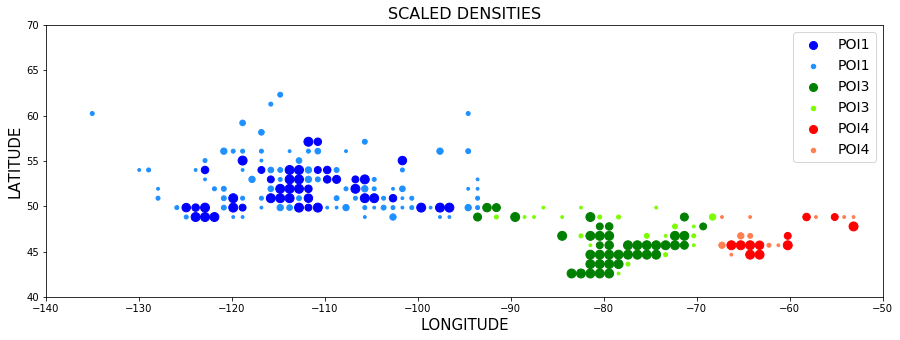

In [26]:
plt.figure(figsize=(15,5))

mask1a = (df_Densities.Nearest_POIID == 'POI1') & (df_Densities.Scaled_density >0)
mask1b = (df_Densities.Nearest_POIID == 'POI1') & (df_Densities.Scaled_density <=0)

mask2a = (df_Densities.Nearest_POIID == 'POI3') & (df_Densities.Scaled_density >0)
mask2b = (df_Densities.Nearest_POIID == 'POI3') & (df_Densities.Scaled_density <=0)

mask3a = (df_Densities.Nearest_POIID == 'POI4') & (df_Densities.Scaled_density >0)
mask3b = (df_Densities.Nearest_POIID == 'POI4') & (df_Densities.Scaled_density <=0)

plt.scatter(\
[i.Lon_centers for i in df_Densities.filter(mask1a).select('Lon_centers').collect()],
[i.Lat_centers for i in df_Densities.filter(mask1a).select('Lat_centers').collect()],
color = 'b', marker = 'o',
s = [4*(i.Scaled_density +10) for i in df_Densities.filter(mask1a).select('Scaled_density').\
     collect()], label='POI1')

plt.scatter(\
[i.Lon_centers for i in df_Densities.filter(mask1b).select('Lon_centers').collect()],
[i.Lat_centers for i in df_Densities.filter(mask1b).select('Lat_centers').collect()],
color = 'dodgerblue', marker = 'o',
s = [4*(i.Scaled_density +10) for i in df_Densities.filter(mask1b).select('Scaled_density').\
     collect()], label='POI1')

plt.scatter(\
[i.Lon_centers for i in df_Densities.filter(mask2a).select('Lon_centers').collect()],
[i.Lat_centers for i in df_Densities.filter(mask2a).select('Lat_centers').collect()],
color = 'g', marker = 'o',
s = [4*(i.Scaled_density +10) for i in df_Densities.filter(mask2a).select('Scaled_density').\
     collect()], label='POI3')

plt.scatter(\
[i.Lon_centers for i in df_Densities.filter(mask2b).select('Lon_centers').collect()],
[i.Lat_centers for i in df_Densities.filter(mask2b).select('Lat_centers').collect()],
color = 'lawngreen', marker = 'o',
s = [4*(i.Scaled_density +10) for i in df_Densities.filter(mask2b).select('Scaled_density').\
     collect()], label='POI3')

plt.scatter(\
[i.Lon_centers for i in df_Densities.filter(mask3a).select('Lon_centers').collect()],
[i.Lat_centers for i in df_Densities.filter(mask3a).select('Lat_centers').collect()],
color = 'r', marker = 'o',
s = [4*(i.Scaled_density +10) for i in df_Densities.filter(mask3a).select('Scaled_density').\
     collect()], label='POI4')

plt.scatter(\
[i.Lon_centers for i in df_Densities.filter(mask3b).select('Lon_centers').collect()],
[i.Lat_centers for i in df_Densities.filter(mask3b).select('Lat_centers').collect()],
color = 'coral', marker = 'o',
s = [4*(i.Scaled_density +10) for i in df_Densities.filter(mask3b).select('Scaled_density').\
     collect()], label='POI4')


plt.ylim((40,70))
plt.xlim((-140,-50))

plt.xlabel('LONGITUDE', fontsize =15)
plt.ylabel('LATITUDE', fontsize =15)
plt.legend(fontsize = 14, loc =1)
plt.title('SCALED DENSITIES', fontsize =16)

plt.show()

We see that the highest requests densities came the densely populated areas around large provincial cities as well as Greater Toronto Area.

## Model: Part 2

In this section, we perform some statistical tests with respect to the Distances in the df_DataSample.Distance column. We first determine whether the Distances for each POI obey the normal distributions with the calculated mean and standard deviation. We will use the normaltest from scipy.stats module. The null-hypothesis states that data obey normal distribution. Running the tests leads to extremely small p_values indicating that the data in all three 'Distance' datasets do not obey normal distribution.

In [27]:
from scipy import stats

_, p1 = stats.normaltest(\
[i.Distance for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI1').\
 select('Distance').collect()])

_, p3 = stats.normaltest(\
[i.Distance for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI3').\
 select('Distance').collect()])

_, p4 = stats.normaltest(\
[i.Distance for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI4').\
 select('Distance').collect()])
   
print('p-value for null-hypothesis that Distances around POI1 obey normal distribution:',p1)
print('p-value for null-hypothesis that Distances around POI3 obey normal distribution:',p3)
print('p-value for null-hypothesis that Distances around POI4 obey normal distribution:',p4)

p-value for null-hypothesis that Distances around POI1 obey normal distribution: 0.0
p-value for null-hypothesis that Distances around POI3 obey normal distribution: 2.30147134039e-286
p-value for null-hypothesis that Distances around POI4 obey normal distribution: 7.28054340406e-36


We can ask a question about a possible form of the distributions of distances. The histogram plots below show that all three distributions for distances from POI are highly non-uniform. Large values are concentrated around certain distances (or in reality certain locations), so it is difficult to think about any well-known texbook continuos distributions the distances can obey. 

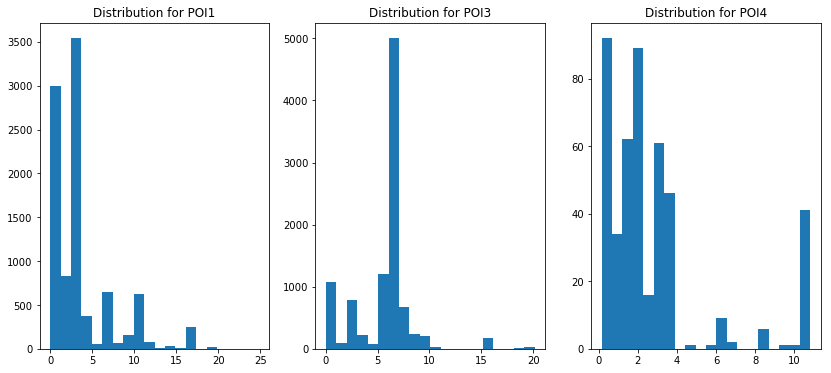

In [29]:
fig, ax = plt.subplots(1, 3, tight_layout=False, figsize=(14,6))

ax[0].hist([i.Distance for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI1').\
 select('Distance').collect()], bins=20)

ax[1].hist([i.Distance for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI3').\
 select('Distance').collect()], bins=20)

ax[2].hist([i.Distance for i in df_DataSample.filter(df_DataSample.Nearest_POIID == 'POI4').\
 select('Distance').collect()], bins=20)

ax[0].set_title('Distribution for POI1')
ax[1].set_title('Distribution for POI3')
ax[2].set_title('Distribution for POI4')

plt.show()